# Astronomy Software Benchmarking 

## Introduction:

#### The Problem:

We want to model quasar winds through synthetic spectra however this takes a great deal of time. One reason is that statisical modeling is a computationally intense process, this can't be changed. The other reason, however, is that many of the rate-limiting steps are written in python, which is very slow and takes a great deal of memory.

#### Possible Solutions: 

There are several python packages that could be imported to replace certain python codes and speed up the process. We could also cut out the middle man and entirely rewrite the code in C or C++ , which can be far more efficiently compiled. 

## Simple Python: 

Before we can improve the spectra generations we first want to make a standard to compare it to in simple python code:


#### First we generate a simple list of wavelengths

In [16]:
# Importing simple packages
import matplotlib.pyplot as plt
import numpy as np

# Importing benchmarking tool
import time

In [17]:
## Specify needed items.

# Start, end wavelength for the spectrum and number of points
startw = 900.       # Angstroms
finalw = 2900.
nspect = 2048

# Number of lines in the spectrum model
nlines = 1000

# Width of each line in gaussian sigma, in Angstroms
lsigma = 4.0

# Width of halfnormal distribution.  We use a halfnormal distribution
# of line depths so most are near zero and only a few are much larger.
halfsig = 0.1

In [18]:
# Generate a wavelength list for the spectrum.
wavels = np.linspace(startw, finalw, nspect, endpoint=True)

#### Next we create a list of wavelengths AND line depths in order to synthesize a spectrum.

In [19]:
# Generate list of line depths and fix up so none are > 1.0
# We want the absolute value of a normal distribution

depths = np.absolute(np.random.normal(0.0, halfsig, nlines))
depths[depths > 1.0] = 1.0
print(depths)

# Generate a list of line wavelengths, which we take as
# uniformly distributed over the spectrum
lwaves = np.random.uniform(startw, finalw, nlines)
print(lwaves)

[2.43877303e-02 4.54998468e-02 1.60927215e-01 3.92258998e-02
 1.44187415e-01 6.20390973e-02 3.43719689e-03 1.18273537e-01
 9.90510204e-02 1.67522660e-01 9.85332543e-02 2.13531855e-01
 1.45663468e-01 7.63316213e-02 8.01993086e-02 9.22319179e-02
 7.04670461e-03 3.30699757e-02 2.48457900e-02 6.77343083e-02
 1.62328398e-02 9.64843356e-02 4.62521506e-02 1.31147052e-01
 9.31577842e-02 2.09698190e-02 1.18812982e-01 1.41298581e-01
 1.43042709e-03 4.17808195e-02 5.57357543e-03 4.37199277e-02
 9.94543470e-02 9.86279092e-02 5.28005925e-02 3.39244891e-02
 3.72101277e-02 9.02236700e-02 9.11530944e-02 6.66783250e-02
 2.00939590e-02 1.39156811e-01 5.94474281e-02 5.02106386e-02
 7.96660682e-03 8.09201149e-02 1.48897749e-02 5.07137093e-02
 1.14229450e-01 1.62783064e-02 6.53755601e-02 2.26114453e-02
 2.21544799e-02 1.25961200e-01 2.86520345e-02 4.72003795e-02
 7.10529976e-02 1.66536616e-01 9.98846422e-02 1.21957793e-01
 4.70415228e-03 1.67545532e-01 2.14781835e-01 3.64756724e-02
 4.10883561e-02 2.699927

#### Now let's make a "spectrum" of a single line 

In [20]:
# Function to return an I/Io spectrum, meaning a spectrum normalized so
# the continuum is 1 everywhere.
def blankspec(npts):
    """
    docstring here
    """
    B = [1.0 for n in range(npts)]
    return B

# Gauss function
from numpy import exp
def gauss(w, cent, depth, sigma):
    """
    docstring here
    """
    gval = -depth * exp(-(w - cent)**2 / 2.0 / sigma**2)
    return gval

In [21]:
# Test with a single line
linecenter = 2023.9
linedepth  = 0.4

blank = blankspec(nspect)
spect = []
for k in range(len(wavels)):
    w = wavels[k]
    d = gauss(w, linecenter, linedepth, lsigma)
    s = blank[k] + d
    spect.append(s)

Text(0, 0.5, 'Spectrum')

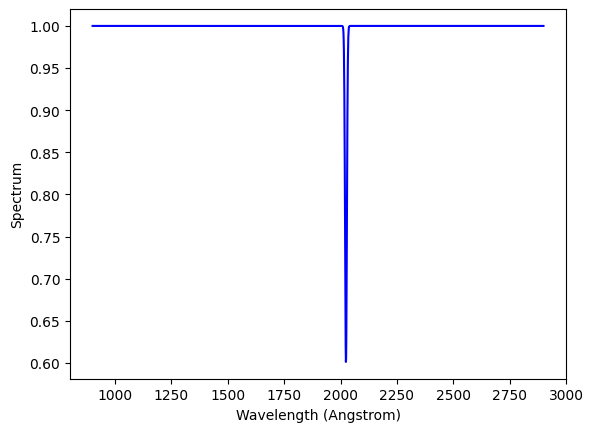

In [22]:
fig, ax = plt.subplots()
ax.plot(wavels, spect, 'blue')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Spectrum')

#### Now we want to make a Full Spectrum

We will do this by 
1. Generating a spectrum with a single line for each line in the list
2. Multiplying all of these spectrums together


In [23]:
# Generate a spectrum with a single line, if there are N lines in the list you get N spectra
def genspec(wavels, lwave, depth, lsigma):
    blank = blankspec(len(wavels))
    spect = []
    for k in range(len(wavels)):
        w = wavels[k]
        d = gauss(w, lwave, depth, lsigma)
        s = blank[k] + d
        spect.append(s)
    return spect

spectrums = []
for N in range(nlines):
    lwave = lwaves[N]
    depth = depths[N]
    spectrums.append(genspec(wavels, lwave, depth, lsigma))
    #plt.plot(wavels, spect, 'blue')
    #plt.show()


# Write to file for c++ testing
with open(r'spectrums.txt', 'w') as fp:
    for item in spectrums:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


Now we want to multipy the lines together to make a proper model of a spectrum, this is the part that can especially slow down our modeling of quesar winds. We're doing this first with a nested for-loop, to compare the differences in time for our methods, we will use time.perf_counter() to count how long it takes to run. 

We will also make a graph of our spectrum to check that we've made a reasonable-looking spectrum. 

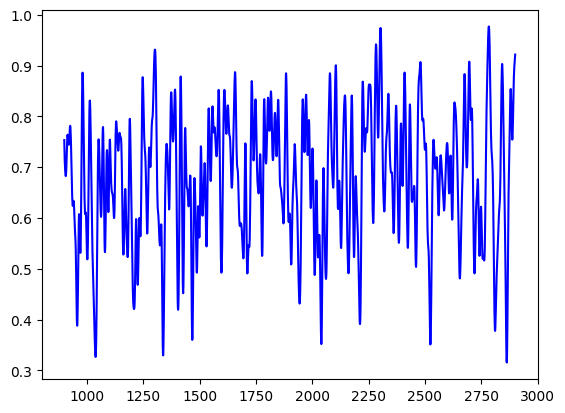

In [24]:
start_time_py = time.perf_counter()

# Multiply all the spectra together
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = [final[n] * spectrums[k][n] for n in range(len(final))]
end_time_py = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [25]:
print('Basic Python Time:',end_time_py - start_time_py)

Basic Python Time: 0.17452120900000523


We have a nice graph and the time elapsed is alright, but it's important to note that this is for a very small number of lines in the model (only 1000) and to do actual research that number will be much higher, dramatically increasing the amount of time it will take to multiply all the lines together. 

## Now with Numpy: 

We'll use numpy as a middleman to mulitplying spectra entirely in C or C++ because [Numpy uses pre-compiled C code](https://numpy.org/doc/stable/user/whatisnumpy.html)

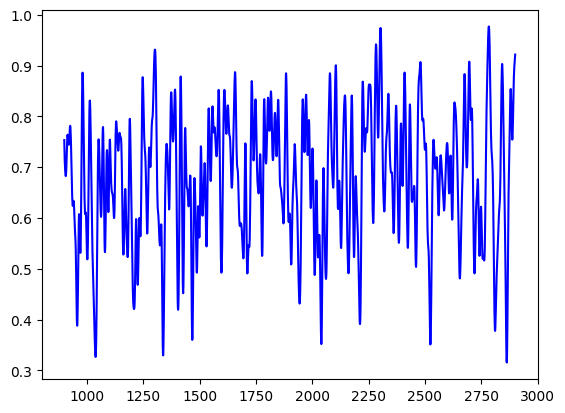

In [26]:
start_time_np = time.perf_counter()
# Multiply all the spectra together with numpy
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = np.multiply(final, spectrums[k])
end_time_np = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [27]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)
print("Numpy is faster than python by a factor of:",(end_time_py - start_time_py)/(end_time_np - start_time_np) )

Python time:  0.17452120900000523
Numpy  time:  0.05141545800000813
Numpy is faster than python by a factor of: 3.3943334512351835


Almost 3 times faster! 

So with just replacing the nested for-loop with a numpy function we've already dramatically reduced the time elapsed. 

Numpy is a very commonly used package, and often seen as one of the best, but we wanted to try at least one other package to compare, for this we chose __math__.

## Now with Math Prod

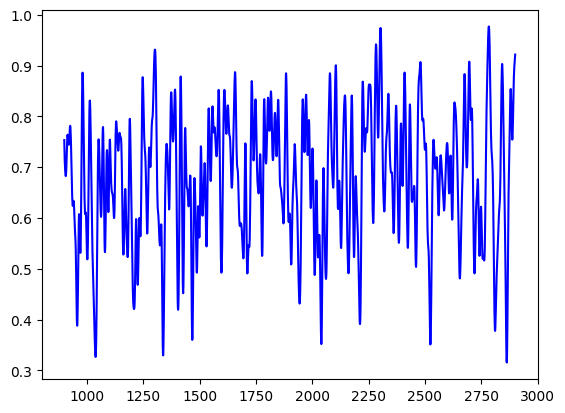

In [28]:

# Python3 program to multiply all values in the
# list using math.prod
 
import math
 
start_time_mp = time.perf_counter()
# Multiply all the spectra together with math
final3 = spectrums[0]
for k in range(1, len(spectrums)):
    final3 = math.prod( spectrums[k])
end_time_mp = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [29]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)
print("Math  time:", end_time_mp - start_time_mp)

Python time:  0.17452120900000523
Numpy  time:  0.05141545800000813
Math  time: 0.054755083000003424


Using math takes _longer_ than even basic python! This is a very interesting result as, like with numpy, [math is written in C](https://realpython.com/python-math-module/). Hopefully by trying this method we have saved some future headache by letting reserachers know not to try _math_. 

Now, we _could_ test other python packages, but it's important to note that, like stated before, most of them run on C or C++, so instead of further messing around with python, let's switch to C++

## Finally, we tried C++

Unfortunately we cannot continue this __Python__ notebook while writing code in C++, but we've ran each of the functions in both python and c++ against random lists of 1000 spectra in order to compare the time elapsed.

For one such test, these are the results:
| Method    | Time (seconds) |
|-----------|----------------|
| pure python | 0.174521       |
| math       | 0.054755       |
| numpy      | 0.051415       |
| c++        | 0.021347       |

As we can see, C++ is the fastest method by a factor of about 2.41.
C++ was also much more consistent in our tests, with it taking about 0.0213 ±10 seconds to run regardless, while the other methods could vary wildly depending on data.